<div align="center"><h1>LSTM Tutorial in Keras</h1>
<div>Bruno Gonçalves</div>
 <a href="http://www.bgoncalves.com/" ><span style="font-size:90%;">www.bgoncalves.com</span></a>
 </div>
<!--h2 align="center", style="font-size=150%">Part I</h2-->

In [1]:
import numpy as np
import re
from collections import Counter
import json

from pprint import pprint
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding
from keras.optimizers import RMSprop

In [3]:
filename = "Frankenstein.txt"

word_regex = re.compile(r'\w+', re.U)

text = "".join(open(filename, 'rt').readlines())

text_words = word_regex.findall(text)

word_counts = Counter(text_words)

word_count_items = list(word_counts.items())
word_count_items.sort(key=lambda x: x[1], reverse=True)

word_list = [word for word, count in word_count_items]
word_dict = dict(zip(word_list, range(len(word_count_items))))

number_words = len(word_counts)

print(number_words)
print(word_list[:20])

7845
['the', 'and', 'I', 'of', 'to', 'my', 'a', 'in', 'was', 'that', 'me', 'with', 'had', 'which', 'but', 'you', 'not', 'his', 'for', 'as']


## Create inputs and labels

We use a window of size __sequence_length__ size that moves __step__ by step over the text. Each such sequence corresponds to a sentence and a row in __input_words__. The word at the next position is our expected __label_words__.

In [4]:
sequence_length = 10
step = 1

input_words = []
label_words = []
for i in range(0, len(text_words) - sequence_length, step):
    input_words.append(text_words[i:i + sequence_length])
    label_words.append(text_words[i + sequence_length])
    
print(len(input_words))

78596


In [5]:
input_words[5000]

['to', 'his', 'cabin', 'Even', 'broken', 'in', 'spirit', 'as', 'he', 'is']

## Vectorization

Now we one hot encode our words, generating a 3D tensor **X** of dimensions *len(input_words)* $\times$ *sequence_length* $\times$ *number_words*. This tensor will be all zeros except for one position per vector which will be one. For the sake of memory efficiency, we define it as a boolean tensor.

Conversely, our expected output **y** is now a 2D matrix of dimensions *len(input_words)* $\times$ *number_words*

In [20]:
X = np.zeros((len(input_words), sequence_length, number_words), dtype=np.bool)
y = np.zeros((len(input_words), number_words), dtype=np.bool)

for i, sentence in enumerate(input_words):
    for t, word in enumerate(sentence):
        X[i, t, word_dict[word]] = 1

    y[i, word_dict[label_words[i]]] = 1
    
print(X.shape)

(78596, 10, 7845)


Define some useful constants

In [8]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 1
NUM_EPOCHS_PER_ITERATION = 3
NUM_PREDS_PER_EPOCH = 10

Define the model

In [19]:
model_simple = Sequential()
model_simple.add(GRU(HIDDEN_SIZE, input_shape=(sequence_length, number_words)))
model_simple.add(Dense(number_words))
model_simple.add(Activation('softmax'))

## Model Compilation

The final remaining step in defining our model is to "compile" it. This signals to Keras that we are done defining layers as well as defining the loss function and optimizer we wish to use. After this step we are ready to start learning our model!

Here we opt to use the **RMSprop** optimizer with a learning rate of **0.01**, together with a **categorical_crossentropy** loss function. Naturally, other choices are possible. 

In [10]:
optimizer = RMSprop(lr=0.01)
model_simple.compile(loss='categorical_crossentropy', optimizer=optimizer)

Before proceeding, let's take a look at the models internal representation. Keras provides us with a simple way of doing this:

In [11]:
pprint(model_simple.get_config())

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
             'activity_regularizer': None,
             'batch_input_shape': (None, 10, 7845),
             'bias_constraint': None,
             'bias_initializer': {'class_name': 'Zeros', 'config': {}},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 1,
             'kernel_constraint': None,
             'kernel_initializer': {'class_name': 'VarianceScaling',
                                    'config': {'distribution': 'uniform',
                                               'mode': 'fan_avg',
                                               'scale': 1.0,
                                               'seed': None}},
             'kernel_regularizer': None,
             'name': 'lstm_1',
             'recurrent_activation': 'hard_sigmoid',
             'recurrent_constraint': None,
             'recurrent_

As expected, we three layers, **LSTM**, **Dense** and **Activation**. The values of all their parameters (mostly default) are also clear.

## Model Traininig

To train the model we need just call the model.fit method with the appropriate parameters. Here we define a training function that combines training multiple iterations with generating predictions based on a specific sentence.

In [12]:
def train_model(model, X_train, y_train, val_split=0.1):
    for iteration in range(NUM_ITERATIONS):
        print("=" * 50)
        print("Iteration #: %d" % (iteration))
        
        # We keep the history result of the trainig step. This provides us with 
        # valueable information about the training procedure that we may use later.
        history = model.fit(X_train, y_train, 
                            validation_split=val_split,
                            batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

        # Choose a specific sentence to use to generate the predictions 
        # and generate NUM_PREDS_PER_EPOCH predictions.
        test_idx = 1502 
        test_words = input_words[test_idx]
        print("Generating from seed: \"%s\"" % (" ".join(test_words)))

        for i in range(NUM_PREDS_PER_EPOCH):
            Xtest = np.zeros((1, sequence_length, number_words))

            for i, word in enumerate(test_words):
                Xtest[0, i, word_dict[word]] = 1

            pred = model.predict(Xtest, verbose=0)[0]
            ypred = word_list[np.argmax(pred)]
            print(" ".join(test_words), "=>", ypred, end=" ")

            # Add the new word to the test instance and 
            # move the window forward 1 step
            test_words = test_words[1:] + [ypred]

            print()
            
    return history, model

Train the model!

Unfortunately, this takes a looooooong time without a GPU, so let's use just a small subset of our data for a quick check that all is fine. 

In [13]:
history, model_simple = train_model(model_simple, X[:2000, :,:], y[:2000, :], 0.25)

Iteration #: 0
Train on 1500 samples, validate on 500 samples
Epoch 1/3
1500/1500 [==============================] - 35s 23ms/step - loss: 8.2253 - val_loss: 7.4987
Epoch 2/3
1500/1500 [==============================] - 26s 17ms/step - loss: 6.4317 - val_loss: 7.9809
Epoch 3/3
1500/1500 [==============================] - 25s 17ms/step - loss: 6.2946 - val_loss: 8.2486
Generating from seed: "of success there will be none to participate my joy"
of success there will be none to participate my joy => a 
success there will be none to participate my joy a => a 
there will be none to participate my joy a a => a 
will be none to participate my joy a a a => a 
be none to participate my joy a a a a => a 
none to participate my joy a a a a a => a 
to participate my joy a a a a a a => a 
participate my joy a a a a a a a => a 
my joy a a a a a a a a => a 
joy a a a a a a a a a => a 


## Save the model we trained for future use

Keras provides us with a simple way to save the model condiguration. Unfortunately, this does not include the training history, just the final result. We save history in a json file.

In [14]:
model_filename = "lstm_bad"
history_dict = history.history

model_simple.save(model_filename + ".h5")
json.dump(history_dict, open(model_filename + ".json", "w"))

## Load a pretrained model

Now we can load a well trained model that is available to us! We also load the training history so that we may visualize it.

In [15]:
history_dict = json.load(open("lstm_simple.json", "r"))
model_simple = load_model("lstm_simple.h5")

Let's check that the model architecture matches what we expect

In [16]:
pprint(model_simple.get_config())

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
             'activity_regularizer': None,
             'batch_input_shape': (None, 10, 7845),
             'bias_constraint': None,
             'bias_initializer': {'class_name': 'Zeros', 'config': {}},
             'bias_regularizer': None,
             'dropout': 0.0,
             'dtype': 'float32',
             'go_backwards': False,
             'implementation': 1,
             'kernel_constraint': None,
             'kernel_initializer': {'class_name': 'VarianceScaling',
                                    'config': {'distribution': 'uniform',
                                               'mode': 'fan_avg',
                                               'scale': 1.0,
                                               'seed': None}},
             'kernel_regularizer': None,
             'name': 'lstm_1',
             'recurrent_activation': 'hard_sigmoid',
             'recurrent_constraint': None,
             'recurrent_

Yep, everything looks fine here. Now, left visualize the training history.

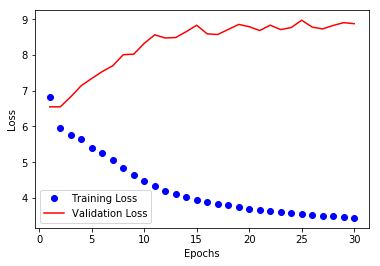

In [17]:
loss = history_dict['loss']
validation_loss = history_dict['val_loss']

epochs = list(range(1, len(loss)+1))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Finally, let's use this loaded model to make some predictions

In [19]:
test_idx = 5000 
test_words = input_words[test_idx]
print("Generating from seed: \"%s\"" % (" ".join(test_words)))

for i in range(NUM_PREDS_PER_EPOCH):
    Xtest = np.zeros((1, sequence_length, number_words))

    for i, word in enumerate(test_words):
        Xtest[0, i, word_dict[word]] = 1

    pred = model_simple.predict(Xtest, verbose=0)[0]
    ypred = word_list[np.argmax(pred)]
    print(" ".join(test_words), "=>", ypred, end=" ")
    
    # Add the new word to the test instance and 
    # move the window forward 1 step
    test_words = test_words[1:] + [ypred]

    print()

Generating from seed: "to his cabin Even broken in spirit as he is"
to his cabin Even broken in spirit as he is => or 
his cabin Even broken in spirit as he is or => to 
cabin Even broken in spirit as he is or to => be 
Even broken in spirit as he is or to be => his 
broken in spirit as he is or to be his => through 
in spirit as he is or to be his through => as 
spirit as he is or to be his through as => the 
as he is or to be his through as the => few 
he is or to be his through as the few => it 
is or to be his through as the few it => is 
